/var/folders/2q/12b4f17x1q988bs0nxprb7pm0000gn/T/ipykernel_23599/1477766300.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start='2020-01-01', end='2025-07-15')
[*********************100%***********************]  1 of 1 completed

Signal distribution:
Signal
 1    772
-1    567
Name: count, dtype: int64

Position distribution:
Position
1    772
0    567
Name: count, dtype: int64


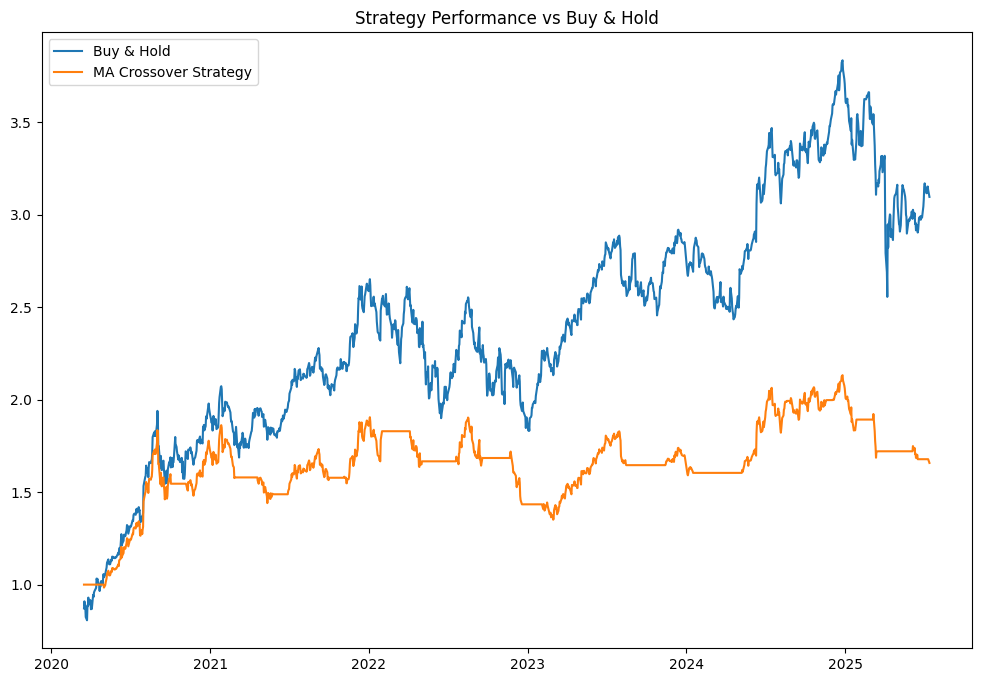


Buy & Hold Return: 209.67%
Strategy Return: 65.80%

=== Performance Metrics ===
Total trading days: 1339
Days in market: 772 (57.7%)
Winning days: 407 (52.7% when in market)
Losing days: 361 (46.8% when in market)

Average win: 1.253%
Average loss: -1.242%
Win/Loss ratio: 1.01

Maximum Drawdown: -29.09%
Sharpe Ratio: 0.57


In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get data
symbol = 'AAPL'
data = yf.download(symbol, start='2020-01-01', end='2025-07-15')

# Calculate moving averages
data['MA_20'] = data['Close'].rolling(window=20).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()

# Drop NaN values
data = data.dropna()

# Generate Signals
data['Signal'] = 0
data.loc[data['MA_20'] > data['MA_50'], 'Signal'] = 1
data.loc[data['MA_20'] <= data['MA_50'], 'Signal'] = -1

# Create position (1 for long, 0 for out)
data['Position'] = 0
data.loc[data['Signal'] == 1, 'Position'] = 1

# Calculate daily returns
data['Daily_Return'] = data['Close'].pct_change()

# Calculate strategy returns
data['Strategy_Return'] = data['Daily_Return'] * data['Position'].shift(1)

# Remove any remaining NaN values
data = data.dropna()

# Calculate cumulative returns
data['Cumulative_Market_Return'] = (1 + data['Daily_Return']).cumprod()
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

# Debug info
print("Signal distribution:")
print(data['Signal'].value_counts())
print("\nPosition distribution:")
print(data['Position'].value_counts())

# Plot
plt.figure(figsize=(12,8))
plt.plot(data['Cumulative_Market_Return'], label='Buy & Hold')
plt.plot(data['Cumulative_Strategy_Return'], label='MA Crossover Strategy')
plt.legend()
plt.title('Strategy Performance vs Buy & Hold')
plt.show()

# Calculate final performance
final_market_return = data['Cumulative_Market_Return'].iloc[-1] - 1
final_strategy_return = data['Cumulative_Strategy_Return'].iloc[-1] - 1

print(f"\nBuy & Hold Return: {final_market_return:.2%}")
print(f"Strategy Return: {final_strategy_return:.2%}")

# Add this to your code to get more insights
# Calculate some key metrics
wins = data[data['Strategy_Return'] > 0]
losses = data[data['Strategy_Return'] < 0]
neutral = data[data['Strategy_Return'] == 0]

print("\n=== Performance Metrics ===")
print(f"Total trading days: {len(data)}")
print(f"Days in market: {data['Position'].sum()} ({data['Position'].sum()/len(data)*100:.1f}%)")
print(f"Winning days: {len(wins)} ({len(wins)/data['Position'].sum()*100:.1f}% when in market)")
print(f"Losing days: {len(losses)} ({len(losses)/data['Position'].sum()*100:.1f}% when in market)")

# Calculate average wins and losses
avg_win = wins['Strategy_Return'].mean()
avg_loss = losses['Strategy_Return'].mean()
print(f"\nAverage win: {avg_win:.3%}")
print(f"Average loss: {avg_loss:.3%}")
print(f"Win/Loss ratio: {abs(avg_win/avg_loss):.2f}")

# Maximum drawdown
cumulative = data['Cumulative_Strategy_Return']
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min()
print(f"\nMaximum Drawdown: {max_drawdown:.2%}")

# Sharpe Ratio (assuming 252 trading days per year)
sharpe = (data['Strategy_Return'].mean() * 252) / (data['Strategy_Return'].std() * np.sqrt(252))
print(f"Sharpe Ratio: {sharpe:.2f}")

/var/folders/2q/12b4f17x1q988bs0nxprb7pm0000gn/T/ipykernel_23599/1895395733.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  buy_dates = touch & (~touch.shift(1).fillna(False))


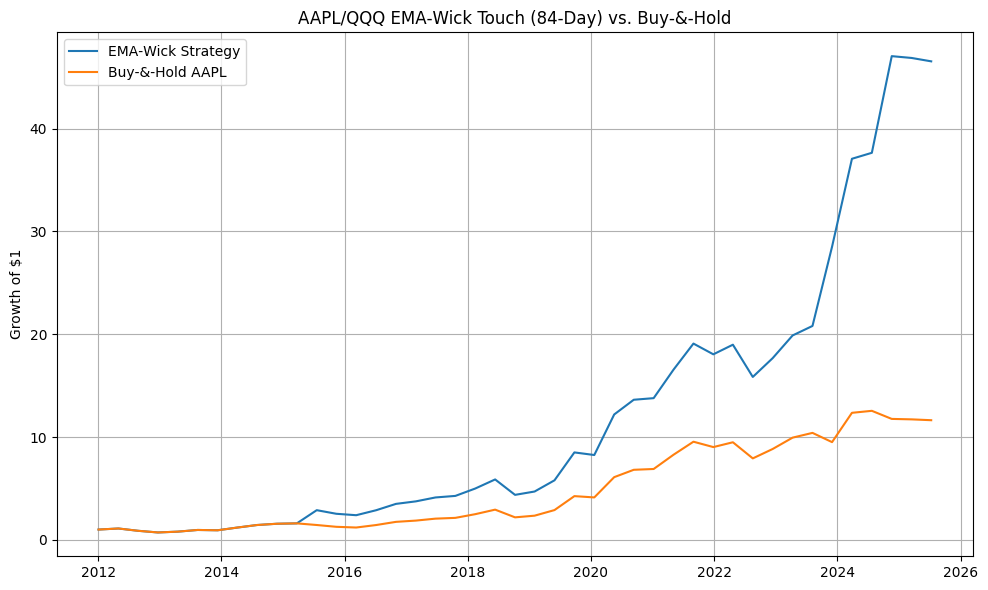

Strategy  | Total: 4555.4% | CAGR: 30.73%
Buy&Hold | Total: 1063.8% | CAGR: 18.68%


In [38]:
# === Apple vs. QQQ EMA‑touch strategy – wick version =======================
# Needs: pandas, numpy, yfinance, matplotlib
# ---------------------------------------------------------------------------

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. ------------------------------------------------------------------------
start = "2012-01-01"
tickers = ["AAPL", "QQQ"]

daily = yf.download(tickers, start=start, progress=False, auto_adjust=False)

adj = daily["Adj Close"]          # close‐to‐close total‑return series
aapl_close  = adj["AAPL"]
qqq_close   = adj["QQQ"]

# 2. ------------------------------------------------------------------------
# Build a *daily* ratio first, then roll it up into 84‑business‑day candles
ratio_daily = aapl_close / qqq_close          # one point per trading day

# Get OHLC on the 84‑B calendar
ratio_84 = ratio_daily.resample("84B").ohlc()   # columns: open high low close
ratio_84.dropna(how="any", inplace=True)        # guard against partial final bar

# 3. ------------------------------------------------------------------------
ema20 = ratio_84["close"].ewm(span=20, adjust=False).mean()

# 4. ------------------------------------------------------------------------
# “Touch” if the candle’s low wick is at or below the EMA
touch = ratio_84["low"] <= ema20

# Fire only once per stretch of Falses  →  Triggers are entry dates
buy_dates = touch & (~touch.shift(1).fillna(False))
buy_dates = buy_dates[buy_dates].index         # DatetimeIndex of entries

# 5. ------------------------------------------------------------------------
# Resample AAPL price to 84‑B closes so equity dates line up
aapl_84_close = aapl_close.resample("84B").last().reindex(ratio_84.index)

# Simulate: add one share (unit) every signal, then hold
units = pd.Series(0, index=ratio_84.index, dtype=int)
units.loc[buy_dates] = 1
cum_units = units.cumsum()

equity = cum_units * aapl_84_close            # $ value of position

# AAPL buy‑and‑hold, normalised to $1 at first candle
bh = aapl_84_close / aapl_84_close.iloc[0]

# 6. ------------------------------------------------------------------------
# Normalise strategy to start at $1 as well
strat_norm = equity / equity.iloc[0]
bh_norm    = bh

plt.figure(figsize=(10,6))
plt.plot(strat_norm, label="EMA‑Wick Strategy")
plt.plot(bh_norm,    label="Buy‑&‑Hold AAPL")
plt.title("AAPL/QQQ EMA‑Wick Touch (84‑Day) vs. Buy‑&‑Hold")
plt.ylabel("Growth of $1")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# 7. ------------------------------------------------------------------------
def perf(s):
    tot = s.iloc[-1] - 1
    yrs = (len(s) * 84) / 252                 # convert 84‑day bars → years
    cagr = (s.iloc[-1]) ** (1 / yrs) - 1
    return tot, cagr

tot_s, cag_s = perf(strat_norm)
tot_b, cag_b = perf(bh_norm)

print(f"Strategy  | Total: {tot_s:6.1%} | CAGR: {cag_s:6.2%}")
print(f"Buy&Hold | Total: {tot_b:6.1%} | CAGR: {cag_b:6.2%}")


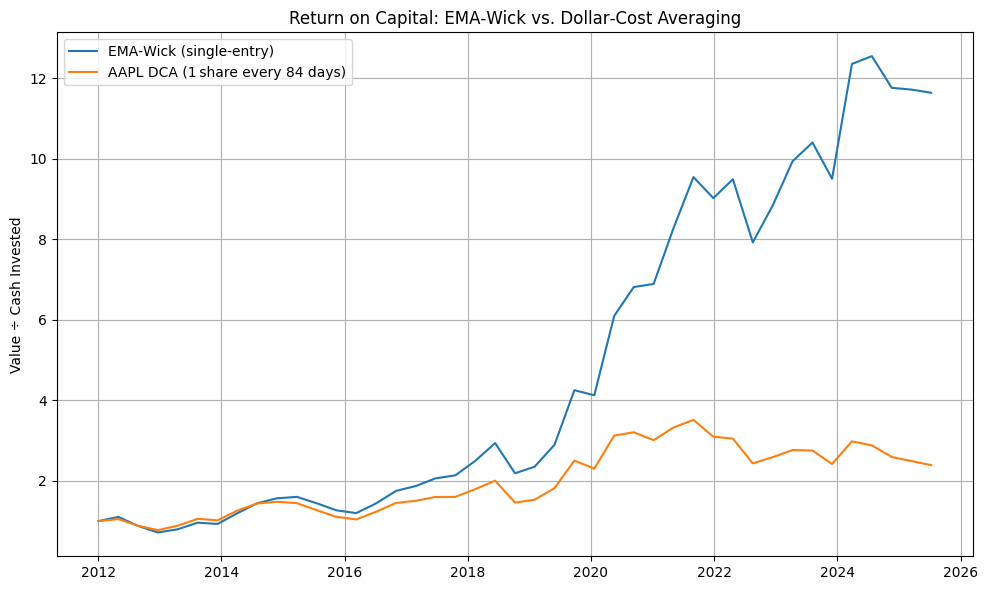

EMA‑Wick ROI multiple:  11.64× | CAGR: 18.68%
DCA ROI multiple:        2.39× | CAGR:  6.27%


In [39]:
# === AAPL/QQQ EMA‑Wick (single‑entry) vs. 84‑day DCA ======================
# Requires: pandas, numpy, yfinance, matplotlib
# --------------------------------------------------------------------------

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. ------------------------------------------------ download daily prices
start   = "2012-01-01"
tickers = ["AAPL", "QQQ"]

daily = yf.download(tickers, start=start, progress=False, auto_adjust=False)

adj        = daily["Adj Close"]          # keep adjusted prices
aapl_close = adj["AAPL"]
qqq_close  = adj["QQQ"]

# 2. ------------------------------------------------ 84‑day candles of ratio
ratio_daily = aapl_close / qqq_close
ratio_84    = ratio_daily.resample("84B").ohlc().dropna()

ema20 = ratio_84["close"].ewm(span=20, adjust=False).mean()

# 3. ------------------------------------------------ single‑entry signal
touch_mask   = ratio_84["low"] <= ema20
first_touch  = touch_mask.idxmax()          # first True date
if not touch_mask.any():
    raise ValueError("No EMA‑wick touch found in sample!")

# 4. ------------------------------------------------ AAPL 84‑day close series
aapl_84 = aapl_close.resample("84B").last().reindex(ratio_84.index)

# --- Your strategy: one purchase, then hold --------------------------------
units_strat = pd.Series(0, index=aapl_84.index, dtype=int)
units_strat.loc[first_touch] = 1
cum_units_strat = units_strat.cumsum()

equity_strat = cum_units_strat * aapl_84
cost_strat   = aapl_84.loc[first_touch]              # $ spent once
roi_strat    = equity_strat / cost_strat             # money multiple

# --- Benchmark: 1 share added every 84‑day candle (DCA) --------------------
units_dca = pd.Series(1, index=aapl_84.index)        # buy 1 each bar
cum_units_dca = units_dca.cumsum()

equity_dca = cum_units_dca * aapl_84
cost_dca   = (units_dca * aapl_84).cumsum()          # cumulative cash in
roi_dca    = equity_dca / cost_dca                   # money multiple

# 5. ------------------------------------------------ plot ROI multiples
plt.figure(figsize=(10,6))
plt.plot(roi_strat, label="EMA‑Wick (single‑entry)")
plt.plot(roi_dca,   label="AAPL DCA (1 share every 84 days)")
plt.title("Return on Capital: EMA‑Wick vs. Dollar‑Cost Averaging")
plt.ylabel("Value ÷ Cash Invested")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. ------------------------------------------------ summary numbers
def finish(series):
    total_mult = series.iloc[-1]
    years = (len(series) * 84) / 252
    cagr = total_mult**(1/years) - 1
    return total_mult, cagr

mult_s, cagr_s = finish(roi_strat)
mult_d, cagr_d = finish(roi_dca)

print(f"EMA‑Wick ROI multiple: {mult_s:6.2f}× | CAGR: {cagr_s:6.2%}")
print(f"DCA ROI multiple:      {mult_d:6.2f}× | CAGR: {cagr_d:6.2%}")

/var/folders/2q/12b4f17x1q988bs0nxprb7pm0000gn/T/ipykernel_23599/1126504976.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aapl_M      = aapl_close.resample("M").last()           # month-end prices


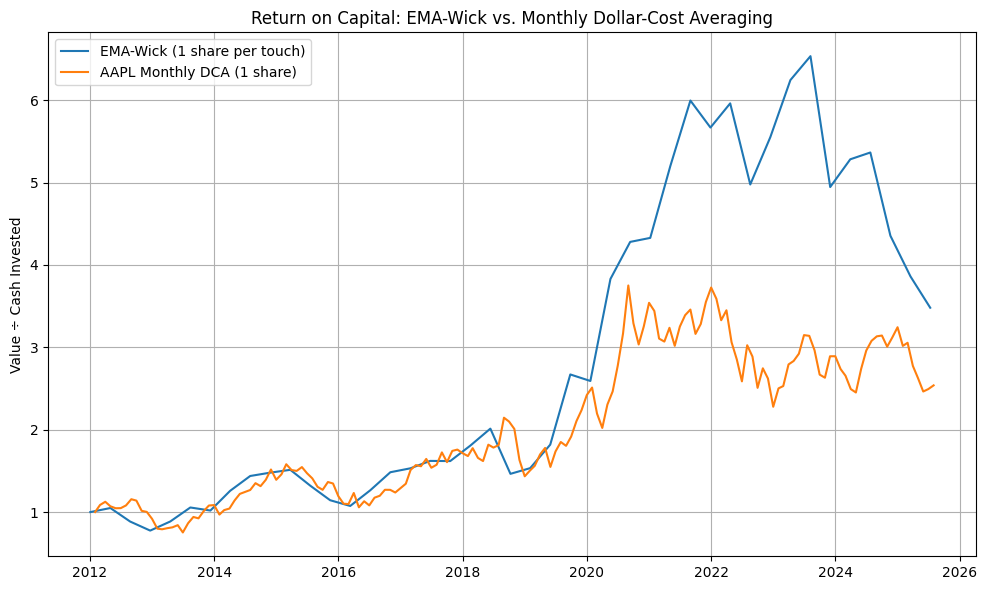

EMA-Wick ROI multiple:   3.48× | CAGR:  9.66%
Monthly DCA multiple:    2.54× | CAGR:  9.66%


In [40]:
# === EMA-Wick Multi-Entry vs. Monthly DCA ==================================
# Needs: pandas, numpy, yfinance, matplotlib
# ---------------------------------------------------------------------------

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. ------------------------------------------------ download daily prices
start   = "2012-01-01"
tickers = ["AAPL", "QQQ"]

daily = yf.download(tickers, start=start, progress=False, auto_adjust=False)

adj        = daily["Adj Close"]          # adjusted prices
aapl_close = adj["AAPL"]
qqq_close  = adj["QQQ"]

# 2. ------------------------------------------------ 84-day candles of the ratio
ratio_daily = aapl_close / qqq_close
ratio_84    = ratio_daily.resample("84B").ohlc().dropna()

ema20 = ratio_84["close"].ewm(span=20, adjust=False).mean()

# 3. ------------------------------------------------ your strategy: buy once per touch
touch_mask   = ratio_84["low"] <= ema20
buy_dates    = ratio_84.index[touch_mask]              # DatetimeIndex of buy bars

aapl_84      = aapl_close.resample("84B").last().reindex(ratio_84.index)

units_strat  = pd.Series(0, index=aapl_84.index, dtype=int)
units_strat.loc[buy_dates] = 1                        # one share per touch
cum_units_s  = units_strat.cumsum()

equity_s     = cum_units_s * aapl_84
cost_s       = (units_strat * aapl_84).cumsum()
roi_s        = equity_s / cost_s                        # value ÷ cost

# 4. ------------------------------------------------ benchmark: MONTHLY DCA
aapl_M      = aapl_close.resample("M").last()           # month-end prices
units_dca   = pd.Series(1, index=aapl_M.index)          # 1 share each month
cum_units_d = units_dca.cumsum()

equity_d    = cum_units_d * aapl_M
cost_d      = (units_dca * aapl_M).cumsum()
roi_d       = equity_d / cost_d

# 5. ------------------------------------------------ plot ROI multiples
plt.figure(figsize=(10,6))
plt.plot(roi_s, label="EMA-Wick (1 share per touch)")
plt.plot(roi_d, label="AAPL Monthly DCA (1 share)")
plt.title("Return on Capital: EMA-Wick vs. Monthly Dollar-Cost Averaging")
plt.ylabel("Value ÷ Cash Invested")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# 6. ------------------------------------------------ summary numbers
def stats(series):
    tot_mult = series.iloc[-1]
    yrs = (series.index[-1] - series.index[0]).days / 365.25
    cagr = tot_mult ** (1/yrs) - 1
    return tot_mult, cagr

mult_s, cagr_s = stats(roi_s)
mult_d, cagr_d = stats(roi_d)

print(f"EMA-Wick ROI multiple: {mult_s:6.2f}× | CAGR: {cagr_s:6.2%}")
print(f"Monthly DCA multiple:  {mult_d:6.2f}× | CAGR: {cagr_s:6.2%}")

/var/folders/2q/12b4f17x1q988bs0nxprb7pm0000gn/T/ipykernel_23599/39054608.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl = yf.download('AAPL', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/2q/12b4f17x1q988bs0nxprb7pm0000gn/T/ipykernel_23599/39054608.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  qqq = yf.download('QQQ', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed



=== Checking for EMA Touches (2012 onwards) ===
Touch on 2013-09-11: Low=0.1880, EMA=0.1897
Touch on 2014-05-13: Low=0.1972, EMA=0.1953


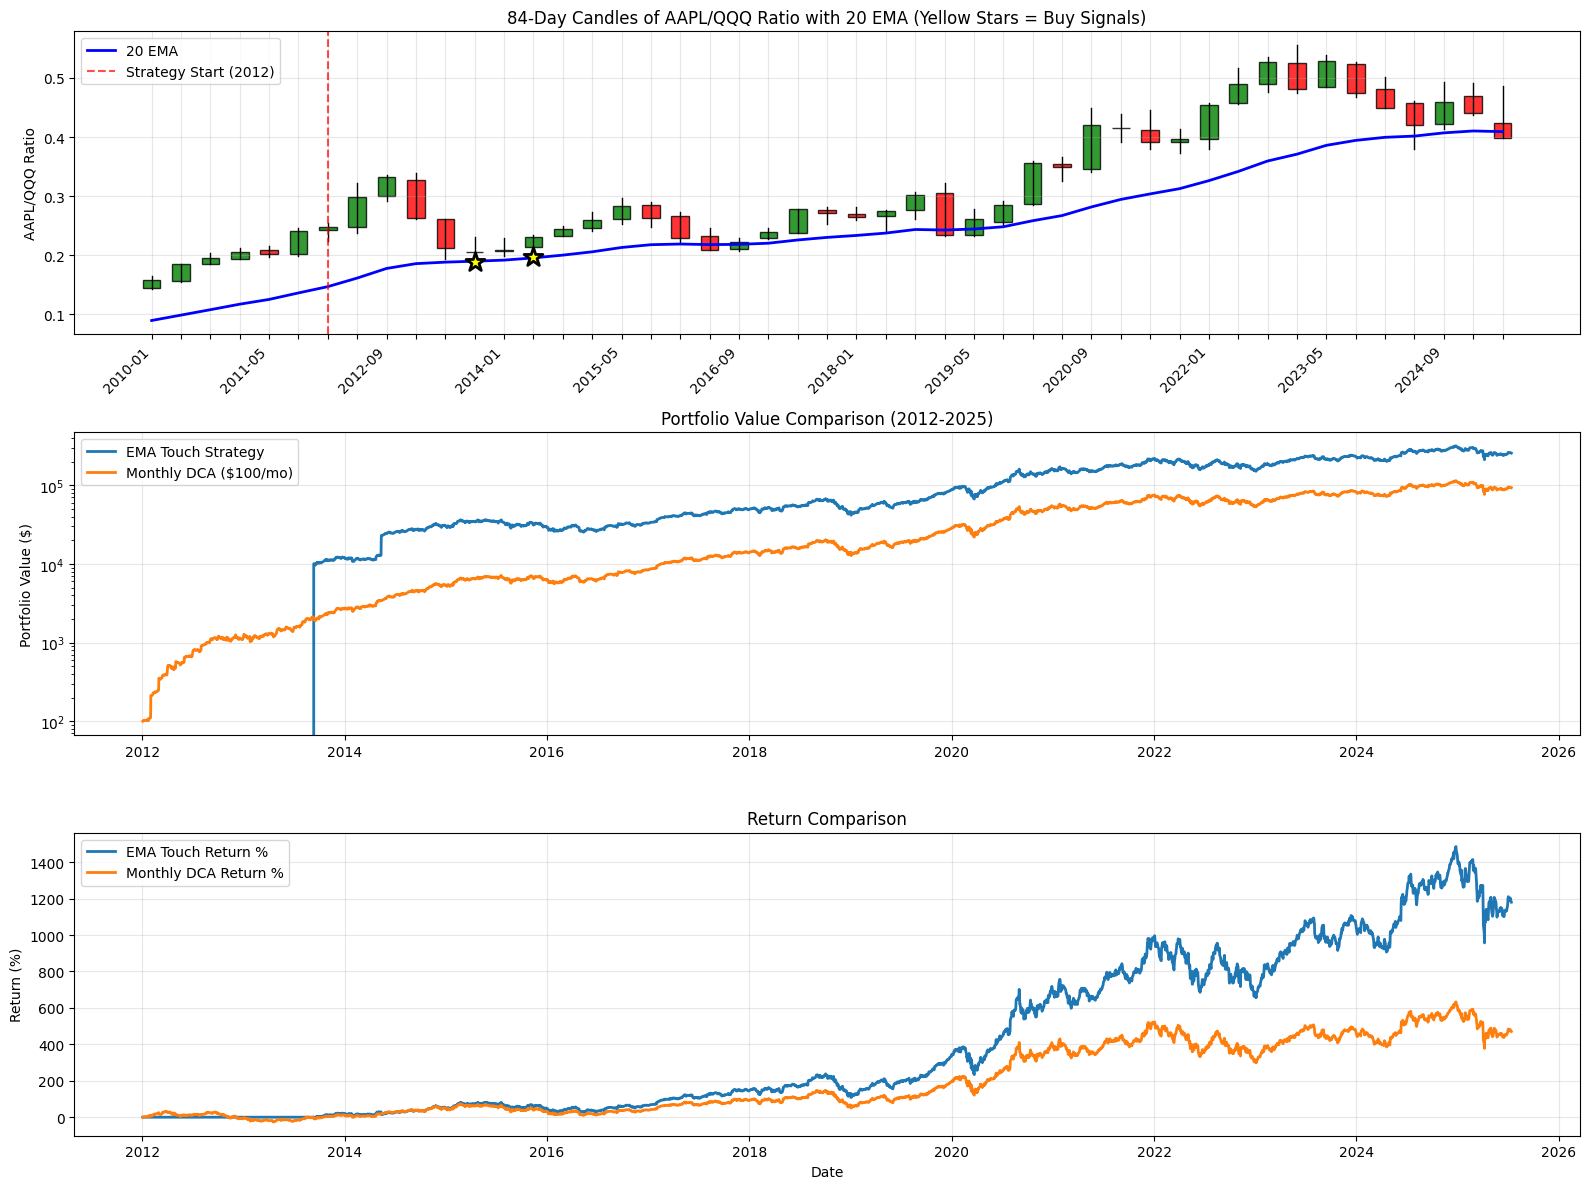


=== EMA Touch Strategy (2012-2025) ===
Number of buys: 2
Total invested: $20,000.00
Final value: $256,081.74
Total return: 1180.41%
Average annual return: 20.79%

=== Monthly DCA Strategy (2012-2025) ===
Total invested: $16,300.00
Final value: $92,987.76
Total return: 470.48%
Average annual return: 13.77%

=== Candle Details Around 2013 ===
2012-09-07: Low=0.2909, EMA=0.1774, Diff=64.0% 
2013-01-10: Low=0.2613, EMA=0.1856, Diff=40.8% 
2013-05-13: Low=0.1942, EMA=0.1881, Diff=3.3% 
2013-09-11: Low=0.1880, EMA=0.1897, Diff=-0.9% *** TOUCH ***


In [46]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Get data for AAPL and QQQ since 2000
start_date = '2000-01-01'
end_date = '2025-07-15'

aapl = yf.download('AAPL', start=start_date, end=end_date)
qqq = yf.download('QQQ', start=start_date, end=end_date)

# Create AAPL/QQQ ratio
data = pd.DataFrame()
data['AAPL'] = aapl['Close']
data['QQQ'] = qqq['Close']
data['Ratio'] = data['AAPL'] / data['QQQ']

# Create 84-day candles for the ratio
window = 84
candles = []

for i in range(0, len(data) - window + 1, window):
    period_data = data['Ratio'].iloc[i:i+window]
    candle = {
        'Open': period_data.iloc[0],
        'High': period_data.max(),
        'Low': period_data.min(),
        'Close': period_data.iloc[-1],
        'Date': data.index[i+window-1]
    }
    candles.append(candle)

# Convert to DataFrame
ratio_84d = pd.DataFrame(candles)
ratio_84d.set_index('Date', inplace=True)

# Calculate 20-period EMA on 84-day candles
ratio_84d['EMA_20'] = ratio_84d['Close'].ewm(span=20, adjust=False).mean()

# Find when 84-day candle low touches EMA (only after 2012)
tolerance = 0.01  # 2% tolerance
ema_buy_signals = []

print("\n=== Checking for EMA Touches (2012 onwards) ===")
for i in range(len(ratio_84d)):
    if ratio_84d.index[i] >= pd.Timestamp('2012-01-01'):
        candle_low = ratio_84d['Low'].iloc[i]
        ema_value = ratio_84d['EMA_20'].iloc[i]
        
        # Check if low touches EMA
        if candle_low <= ema_value * (1 + tolerance) and candle_low >= ema_value * (1 - tolerance):
            buy_date = ratio_84d.index[i]
            ema_buy_signals.append(buy_date)
            print(f"Touch on {buy_date.strftime('%Y-%m-%d')}: Low={candle_low:.4f}, EMA={ema_value:.4f}")

# Create figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))

# Plot 1: 84-day candles with EMA (show from 2010 for context)
plot_start = pd.Timestamp('2010-01-01')
plot_data = ratio_84d[ratio_84d.index >= plot_start]

x_positions = []
x_labels = []

for idx, (i, row) in enumerate(plot_data.iterrows()):
    x_positions.append(idx)
    
    open_price = row['Open']
    high = row['High']
    low = row['Low']
    close = row['Close']
    
    # Determine color
    color = 'green' if close >= open_price else 'red'
    
    # Plot high-low line
    ax1.plot([idx, idx], [low, high], color='black', linewidth=1)
    
    # Plot open-close rectangle
    height = abs(close - open_price)
    bottom = min(open_price, close)
    rect = Rectangle((idx-0.3, bottom), 0.6, height, 
                    facecolor=color, edgecolor='black', alpha=0.8)
    ax1.add_patch(rect)
    
    # Mark buy signals
    if i in ema_buy_signals:
        ax1.scatter(idx, low, color='yellow', s=200, marker='*', 
                   edgecolor='black', linewidth=2, zorder=5)
    
    # Create x-axis labels (show every 4th candle)
    if idx % 4 == 0:
        x_labels.append(i.strftime('%Y-%m'))
    else:
        x_labels.append('')

# Plot EMA
ax1.plot(range(len(plot_data)), plot_data['EMA_20'], 
         color='blue', linewidth=2, label='20 EMA')

# Add vertical line at 2012
start_2012_idx = len(ratio_84d[ratio_84d.index < pd.Timestamp('2012-01-01')]) - len(ratio_84d[ratio_84d.index < plot_start])
if start_2012_idx >= 0:
    ax1.axvline(x=start_2012_idx, color='red', linestyle='--', alpha=0.7, label='Strategy Start (2012)')

ax1.set_xticks(range(len(plot_data)))
ax1.set_xticklabels(x_labels, rotation=45, ha='right')
ax1.set_ylabel('AAPL/QQQ Ratio')
ax1.set_title('84-Day Candles of AAPL/QQQ Ratio with 20 EMA (Yellow Stars = Buy Signals)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Only show every 4th label to avoid crowding
for i, label in enumerate(ax1.xaxis.get_ticklabels()):
    if i % 4 != 0:
        label.set_visible(False)

# Strategy Implementation (starting from 2012)
strategy_start = pd.Timestamp('2012-01-01')
strategy_data = data[data.index >= strategy_start]

# Strategy 1: EMA Touch Strategy
ema_portfolio = pd.DataFrame(index=strategy_data.index)
ema_portfolio['Shares'] = 0.0
ema_portfolio['Invested'] = 0.0

ema_shares = 0
ema_invested = 0

for buy_date in ema_buy_signals:
    if buy_date in strategy_data.index:
        aapl_price = strategy_data.loc[buy_date, 'AAPL']
        shares_bought = 10000 / aapl_price
        ema_shares += shares_bought
        ema_invested += 10000
        
        ema_portfolio.loc[buy_date:, 'Shares'] = ema_shares
        ema_portfolio.loc[buy_date:, 'Invested'] = ema_invested

ema_portfolio['Value'] = ema_portfolio['Shares'] * strategy_data['AAPL']

# Strategy 2: Monthly DCA (starting 2012)
monthly_portfolio = pd.DataFrame(index=strategy_data.index)
monthly_portfolio['Shares'] = 0.0
monthly_portfolio['Invested'] = 0.0

monthly_shares = 0
monthly_invested = 0

for year in range(2012, 2026):
    for month in range(1, 13):
        try:
            month_data = strategy_data[(strategy_data.index.year == year) & 
                                      (strategy_data.index.month == month)]
            if len(month_data) > 0:
                buy_date = month_data.index[0]
                aapl_price = strategy_data.loc[buy_date, 'AAPL']
                shares_bought = 100 / aapl_price
                monthly_shares += shares_bought
                monthly_invested += 100
                
                monthly_portfolio.loc[buy_date:, 'Shares'] = monthly_shares
                monthly_portfolio.loc[buy_date:, 'Invested'] = monthly_invested
        except:
            pass

monthly_portfolio['Value'] = monthly_portfolio['Shares'] * strategy_data['AAPL']

# Calculate returns
ema_portfolio['Return'] = (ema_portfolio['Value'] / ema_portfolio['Invested']) - 1
ema_portfolio['Return'] = ema_portfolio['Return'].fillna(0)

monthly_portfolio['Return'] = (monthly_portfolio['Value'] / monthly_portfolio['Invested']) - 1
monthly_portfolio['Return'] = monthly_portfolio['Return'].fillna(0)

# Plot 2: Portfolio Values
ax2.plot(ema_portfolio.index, ema_portfolio['Value'], label='EMA Touch Strategy', linewidth=2)
ax2.plot(monthly_portfolio.index, monthly_portfolio['Value'], label='Monthly DCA ($100/mo)', linewidth=2)
ax2.set_ylabel('Portfolio Value ($)')
ax2.set_title('Portfolio Value Comparison (2012-2025)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# Plot 3: Returns
ax3.plot(ema_portfolio.index, ema_portfolio['Return'] * 100, label='EMA Touch Return %', linewidth=2)
ax3.plot(monthly_portfolio.index, monthly_portfolio['Return'] * 100, label='Monthly DCA Return %', linewidth=2)
ax3.set_ylabel('Return (%)')
ax3.set_xlabel('Date')
ax3.set_title('Return Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print("\n=== EMA Touch Strategy (2012-2025) ===")
print(f"Number of buys: {len(ema_buy_signals)}")
print(f"Total invested: ${ema_invested:,.2f}")
if ema_invested > 0:
    print(f"Final value: ${ema_portfolio['Value'].iloc[-1]:,.2f}")
    print(f"Total return: {ema_portfolio['Return'].iloc[-1]:.2%}")
    print(f"Average annual return: {((ema_portfolio['Value'].iloc[-1] / ema_invested) ** (1/13.5) - 1):.2%}")

print("\n=== Monthly DCA Strategy (2012-2025) ===")
print(f"Total invested: ${monthly_invested:,.2f}")
print(f"Final value: ${monthly_portfolio['Value'].iloc[-1]:,.2f}")
print(f"Total return: {monthly_portfolio['Return'].iloc[-1]:.2%}")
print(f"Average annual return: {((monthly_portfolio['Value'].iloc[-1] / monthly_invested) ** (1/13.5) - 1):.2%}")

# Show some candle details around 2013
print("\n=== Candle Details Around 2013 ===")
candles_2013 = ratio_84d[(ratio_84d.index >= pd.Timestamp('2012-06-01')) & 
                         (ratio_84d.index <= pd.Timestamp('2014-01-01'))]
for date, row in candles_2013.iterrows():
    touch = "*** TOUCH ***" if date in ema_buy_signals else ""
    print(f"{date.strftime('%Y-%m-%d')}: Low={row['Low']:.4f}, EMA={row['EMA_20']:.4f}, "
          f"Diff={(row['Low']/row['EMA_20']-1)*100:.1f}% {touch}")

/var/folders/2q/12b4f17x1q988bs0nxprb7pm0000gn/T/ipykernel_23599/3717107806.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl_data = yf.download('AAPL', start='2000-01-01')
[*********************100%***********************]  1 of 1 completed
/var/folders/2q/12b4f17x1q988bs0nxprb7pm0000gn/T/ipykernel_23599/3717107806.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  qqq_data = yf.download('QQQ', start='2000-01-01')
[*********************100%***********************]  1 of 1 completed
/var/folders/2q/12b4f17x1q988bs0nxprb7pm0000gn/T/ipykernel_23599/3717107806.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  10000.            9156.90332416    9290.89707659 ... 2541592.69658183
 2543019.61229541 2547537.66468133]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  primary_strategy_portfolio.loc[val

--- Strategy Performance Summary ---
Primary Strategy Buy Date: 2000-01-03
Primary Strategy Initial Investment: $10,000.00
Primary Strategy Final Portfolio Value: $2,547,537.66

--- DCA Strategy ---
DCA Total Amount Invested: $104,000.00
DCA Strategy Final Portfolio Value: $595,721.80


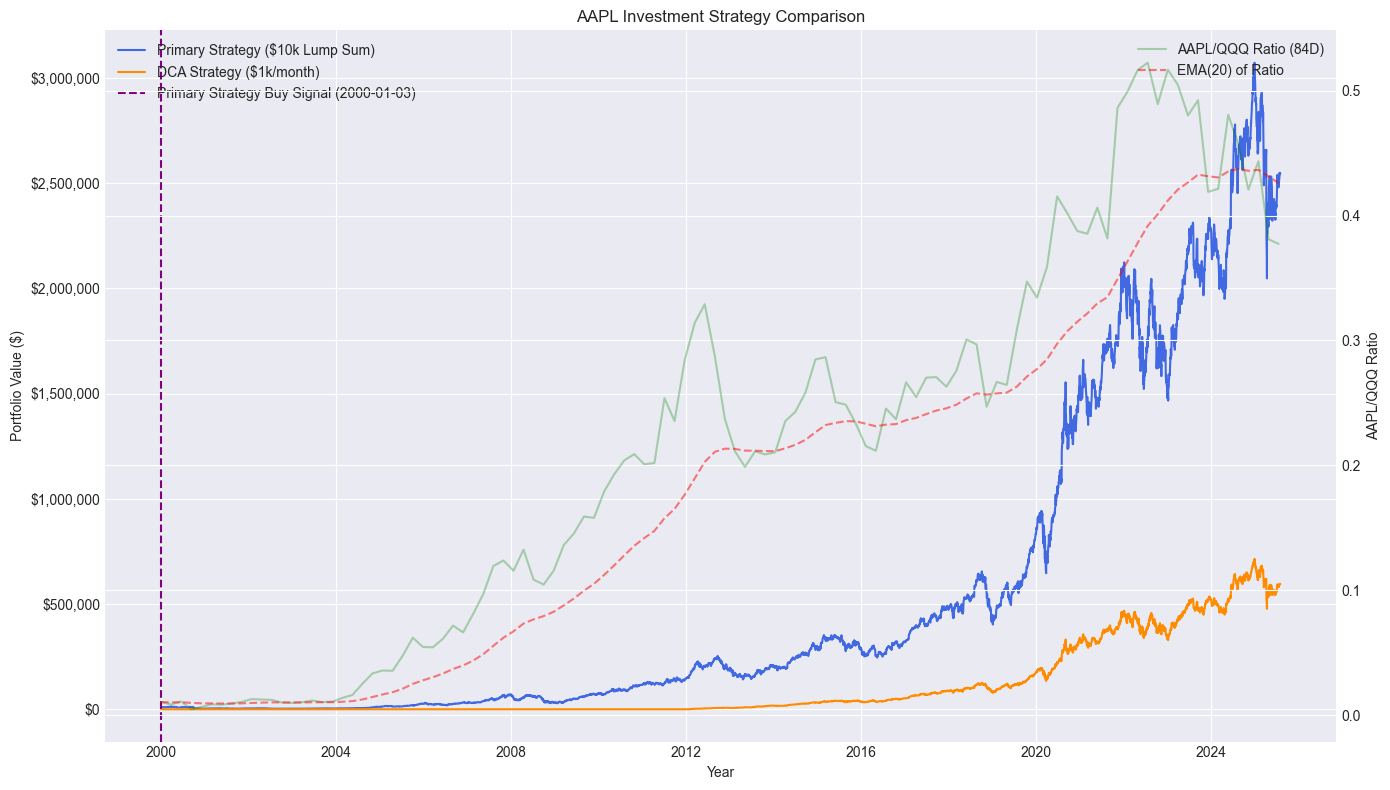

In [59]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

def run_strategy_analysis():
    """
    This function runs the full analysis of the two trading strategies for Apple stock.
    1. Downloads data for AAPL and QQQ.
    2. Implements the primary strategy based on the AAPL/QQQ ratio and an 84-day EMA.
    3. Implements a Dollar-Cost Averaging (DCA) strategy.
    4. Compares the performance of the two strategies.
    5. Plots the results.
    """

    # --- 1. Data Download and Preparation ---
    try:
        # Download historical data for Apple (AAPL) and QQQ since the year 2000
        # By default, yfinance returns adjusted prices in the 'Close' column.
        aapl_data = yf.download('AAPL', start='2000-01-01')
        qqq_data = yf.download('QQQ', start='2000-01-01')

        if aapl_data.empty or qqq_data.empty:
            print("Could not download data. Please check the ticker symbols and your internet connection.")
            return

    except Exception as e:
        print(f"An error occurred during data download: {e}")
        return

    # Calculate the AAPL/QQQ ratio using closing prices (which are adjusted by default)
    data = pd.DataFrame(index=aapl_data.index)
    data['AAPL_Close'] = aapl_data['Close']
    data['QQQ_Close'] = qqq_data['Close']
    data['Ratio'] = data['AAPL_Close'] / data['QQQ_Close']
    data.dropna(inplace=True)

    # --- 2. Primary Strategy: AAPL/QQQ Ratio Crossover ---
    # Resample the daily ratio data to an 84-day timeframe
    resampled_data = data['Ratio'].resample('84D').ohlc()

    # Calculate the 20-period EMA of the 84-day closing ratio
    resampled_data['EMA20'] = resampled_data['close'].ewm(span=20, adjust=False).mean()
    resampled_data.dropna(inplace=True)

    # Find the first instance where the low of the 84-day candle touches the EMA(20)
    buy_signal = resampled_data[resampled_data['low'] <= resampled_data['EMA20']]

    primary_strategy_portfolio = pd.DataFrame(index=data.index)
    primary_strategy_portfolio['AAPL_Value'] = 0

    if not buy_signal.empty:
        buy_date = buy_signal.index[0]
        initial_investment = 10000
        
        # Get AAPL price at the time of the buy signal
        # Find the first valid index in the original data at or after the buy_date
        valid_buy_date = data.loc[buy_date:].index[0]
        buy_price = data.loc[valid_buy_date]['AAPL_Close']
        shares_bought = initial_investment / buy_price
        
        # Calculate the portfolio value over time
        primary_strategy_portfolio.loc[valid_buy_date:, 'AAPL_Value'] = shares_bought * data.loc[valid_buy_date:, 'AAPL_Close']
        primary_strategy_portfolio['AAPL_Value'] = primary_strategy_portfolio['AAPL_Value'].replace(0, method='ffill')


    # --- 3. DCA Strategy: Monthly Investment ---
    dca_start_date = '2012-01-01'
    monthly_investment = 1000
    dca_portfolio = pd.DataFrame(index=data.index)
    dca_portfolio['Total_Investment'] = 0
    dca_portfolio['Shares_Held'] = 0
    dca_portfolio['Portfolio_Value'] = 0

    # Filter data for the DCA period
    dca_data = data[data.index >= dca_start_date].copy()
    
    # Get the first trading day of each month
    monthly_buy_days = dca_data.resample('MS').first().index

    total_investment_dca = 0
    total_shares_dca = 0

    for date in data.index:
        if date >= pd.to_datetime(dca_start_date) and date in monthly_buy_days:
            # Invest $1000 on the first trading day of the month
            buy_price_dca = data.loc[date]['AAPL_Close']
            shares_bought_dca = monthly_investment / buy_price_dca
            total_shares_dca += shares_bought_dca
            total_investment_dca += monthly_investment
        
        if date >= pd.to_datetime(dca_start_date):
            dca_portfolio.loc[date, 'Shares_Held'] = total_shares_dca
            dca_portfolio.loc[date, 'Total_Investment'] = total_investment_dca
            dca_portfolio.loc[date, 'Portfolio_Value'] = total_shares_dca * data.loc[date]['AAPL_Close']


    # --- 4. Performance Comparison ---
    final_primary_value = primary_strategy_portfolio['AAPL_Value'].iloc[-1]
    final_dca_value = dca_portfolio['Portfolio_Value'].iloc[-1]
    final_dca_investment = dca_portfolio['Total_Investment'].iloc[-1]

    print("--- Strategy Performance Summary ---")
    if not buy_signal.empty:
        print(f"Primary Strategy Buy Date: {buy_date.date()}")
        print(f"Primary Strategy Initial Investment: ${initial_investment:,.2f}")
        print(f"Primary Strategy Final Portfolio Value: ${final_primary_value:,.2f}")
    else:
        print("Primary Strategy: No buy signal was triggered.")

    print("\n--- DCA Strategy ---")
    print(f"DCA Total Amount Invested: ${final_dca_investment:,.2f}")
    print(f"DCA Strategy Final Portfolio Value: ${final_dca_value:,.2f}")


    # --- 5. Plotting the Results ---
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plotting the portfolio values
    ax1.plot(primary_strategy_portfolio.index, primary_strategy_portfolio['AAPL_Value'], label='Primary Strategy ($10k Lump Sum)', color='royalblue')
    ax1.plot(dca_portfolio.index, dca_portfolio['Portfolio_Value'], label='DCA Strategy ($1k/month)', color='darkorange')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.set_title('AAPL Investment Strategy Comparison')
    ax1.legend(loc='upper left')
    ax1.tick_params(axis='y')
    ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))


    # Create a second y-axis for the AAPL/QQQ ratio and EMA
    ax2 = ax1.twinx()
    ax2.plot(resampled_data.index, resampled_data['close'], label='AAPL/QQQ Ratio (84D)', color='green', alpha=0.3)
    ax2.plot(resampled_data.index, resampled_data['EMA20'], label='EMA(20) of Ratio', color='red', linestyle='--', alpha=0.5)
    ax2.set_ylabel('AAPL/QQQ Ratio')
    ax2.legend(loc='upper right')
    
    if not buy_signal.empty:
        ax1.axvline(x=buy_date, color='purple', linestyle='--', label=f'Primary Strategy Buy Signal ({buy_date.date()})')
        ax1.legend(loc='upper left')


    fig.tight_layout()
    plt.show()

if __name__ == '__main__':
    run_strategy_analysis()

